In [7]:
import os
import requests

#input your API key generated from your Nvidia account 
os.environ['NGC_API_KEY'] = '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'  # Use your regenerated key
print(os.environ.get('NGC_API_KEY'))

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


In [8]:
#Check if your API key is valid
url = "https://api.ngc.nvidia.com/v2/users/me"
headers = {'Authorization': f'Bearer {os.environ.get("NGC_API_KEY")}'}

r = requests.get(url, headers=headers)
print(f"Status: {r.status_code}")
# 200 means that the key is valid 

Status: 200


In [9]:
#check if NIM is healthy and connected 
r = requests.get("http://corrdiff-nim-service-laurahu:8000/v1/health/ready")
if r.status_code == 200:
   print("NIM is healthy!")
   print("Response:", r.text)
else:
   print("NIM is not ready!")
   print("Status:", r.status_code)
   print("Response:", r.text)

NIM is healthy!
Response: {"status":"ready"}


If you get an error message saying that *Name or service not known*, that means your NIM is not connected. Please wait a couple of minutes after the NIM starts running to run this command.

In [10]:
from datetime import datetime, timedelta
import numpy as np
import torch
from earth2studio.data import GEFS_FX, HRRR, GEFS_FX_721x1440

# Inputs 
GEFS_SELECT_VARIABLES = [
    "u10m", 
    "v10m",
    "t2m",
    "r2m",
    "sp",
    "msl",
    "tcwv",
]

GEFS_VARIABLES = [
    "u1000",
    "u925",
    "u850",
    "u700",
    "u500",
    "u250",
    "v1000",
    "v925",
    "v850",
    "v700",
    "v500",
    "v250",
    "z1000",
    "z925",
    "z850",
    "z700",
    "z500",
    "z200",
    "t1000",
    "t925",
    "t850",
    "t700",
    "t500",
    "t100",
    "r1000",
    "r925",
    "r850",
    "r700",
    "r500",
    "r100",
]

ds_gefs = GEFS_FX(cache=True)
ds_gefs_select = GEFS_FX_721x1440(cache=True, member="gec00")

# Function that processes the input 

def fetch_input_gefs(
    time: datetime, lead_time: timedelta, content_dtype: str = "float32"
):
    """Fetch input GEFS data and place into a single numpy array

    Parameters
    ----------
    time : datetime
        Time stamp to fetch
    lead_time : timedelta
        Lead time to fetch
    filename : str
        File name to save input array to
    content_dtype : str
        Numpy dtype to save numpy
    """
    dtype = np.dtype(getattr(np, content_dtype))
    
    # Fetch high-res select GEFS input data
    select_data = ds_gefs_select(time, lead_time, GEFS_SELECT_VARIABLES)
    select_data = select_data.values
    # Crop to bounding box [225, 21, 300, 53]
    select_data = select_data[:, 0, :, 148:277, 900:1201].astype(dtype)
    assert select_data.shape == (1, len(GEFS_SELECT_VARIABLES), 129, 301)

    # Fetch GEFS input data
    pressure_data = ds_gefs(time, lead_time, GEFS_VARIABLES)
    
    # Interpolate to 0.25 grid to tensor using nearest neighbor interpolation
    pressure_data = torch.nn.functional.interpolate(
        torch.Tensor(pressure_data.values),
        (len(GEFS_VARIABLES), 721, 1440),
        mode="nearest",
    )
    #converts back from tensors to numpy array
    pressure_data = pressure_data.numpy()
    # Crop to bounding box [225, 21, 300, 53]
    pressure_data = pressure_data[:, 0, :, 148:277, 900:1201].astype(dtype)
    assert pressure_data.shape == (1, len(GEFS_VARIABLES), 129, 301)

    # Create lead time field in 3 hours increments 
    lead_hour = int(lead_time.total_seconds() // (3 * 60 * 60)) * np.ones(
        (1, 1, 129, 301)
    ).astype(dtype)

    input_data = np.concatenate([select_data, pressure_data, lead_hour], axis=1)[None]
    return input_data 

#input_data = [batch dimension = 1, input dimension = 1, 
               #variable name = select data + pressure data + lead hour = 38,
                # latitude = 129, longitude = 301



Fetching GEFS data:   0%|          | 0/7 [00:00<?, ?it/s]

2026-02-02 01:12:19.383 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 11674223-456215
2026-02-02 01:12:19.387 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 17307860-None
2026-02-02 01:12:19.389 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 7593930-805493
2026-02-02 01:12:19.391 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 6765870-828060
2026-02-02 01:12:19.393 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 1760549-739209
2026-02-02 01:12:19.395 | DEBUG    

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-02 01:12:20.619 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 1922846-112770
2026-02-02 01:12:20.622 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 5848841-234297
2026-02-02 01:12:20.624 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 4234498-167628
2026-02-02 01:12:20.626 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 6605171-244657
2026-02-02 01:12:20.627 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 9595872-234785
2026-02-02 01:12:20.629 | DEBUG    | ear

Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 34.33it/s]

<class 'numpy.ndarray'> (1, 1, 38, 129, 301) float32


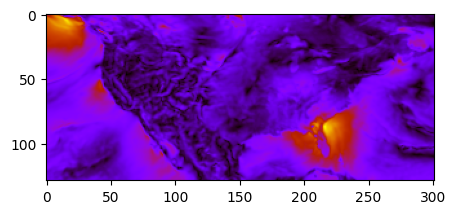

In [22]:
import matplotlib.pyplot as plt

time = datetime(2024, 9, 27) # initial condition 
lead_time1 = timedelta(hours = 6) # model run time 
input_array = fetch_input_gefs(time, lead_time1)

#ensure the dimension of input is correct 
print(type(input_array), getattr(input_array, "shape", None), getattr(input_array, "dtype", None))

np.save("corrdiff_inputs.npy", input_array)

#check if the input is loaded correctly 
input = np.load("corrdiff_inputs.npy")
wind_input = np.sqrt(input[0, 0, 0]**2 + input[0, 0, 1]**2)
fig, ax = plt.subplots(1,1, figsize=(5,3))

ax.imshow(wind_input, cmap="gnuplot")


In [23]:
import io
import tarfile
from pathlib import Path
import numpy as np
import requests
import tqdm

url = f"http://corrdiff-nim-service-laurahu:8000/v1/infer"
files = {
    "input_array": ("input_array", open("corrdiff_inputs.npy", "rb")),
}
data = {
    "samples": 8,
    "steps": 14,
    "seed": 0,
}
headers = {
    "accept": "application/x-tar",
}
print("Sending post request to NIM")
r = requests.post(url, headers=headers, data=data, files=files, timeout=3000)
if r.status_code != 200:
    raise Exception(r.content)
else:
    # Dump response to file
    with open("output.tar", "wb") as tar:
        tar.write(r.content)
print("Done!")

Sending post request to NIM
Done!


In [24]:
#check if the raw outputs make sense 

with tarfile.open("output.tar") as tar:
    for i, member in enumerate(tar.getmembers()):
        arr_file = io.BytesIO()
        arr_file.write(tar.extractfile(member).read())
        arr_file.seek(0)
        data = np.load(arr_file)

# A function that checks model outputs
def summarize(name, a):
    a = np.asarray(a)
    print(
        f"{name:8s}",
        "shape", a.shape,
        "finite", np.isfinite(a).all(),
        "min/max", float(np.nanmin(a)), float(np.nanmax(a)),
        "standard deviation", np.std(a),
        "p1/p50/p99", np.nanpercentile(a, [1,50,99]).tolist()
    )


var_names = ["u10m","v10m","t2m","tp","csnow","cicep","cfrzr","crain"]

B = 0
for vi, name in enumerate(var_names):
    x = data[B, :, vi, :, :]  # (S,H,W)
    summarize(name, x)
    print("----------")

print('==============')

B = 0
for vi, name in enumerate(var_names):
    x = input_array[B, :, vi, :, :]  # (S,H,W)
    summarize(name, x)
    print("----------")

u10m     shape (1, 1056, 1792) finite True min/max -6.1481146812438965 15.537116050720215 standard deviation 2.0452864 p1/p50/p99 [0.22649850666522983, 4.9853196144104, 9.743034963607787]
----------
v10m     shape (1, 1056, 1792) finite True min/max -10.515488624572754 12.607705116271973 standard deviation 2.4086041 p1/p50/p99 [-3.9501616954803467, 1.6451997756958008, 7.250546584129332]
----------
t2m      shape (1, 1056, 1792) finite True min/max 289.2947998046875 341.83355712890625 standard deviation 5.569005 p1/p50/p99 [303.78962860107424, 316.77593994140625, 329.7084045410156]
----------
tp       shape (1, 1056, 1792) finite True min/max -2.9044203758239746 2.2931580543518066 standard deviation 0.53356236 p1/p50/p99 [-1.553423969745636, -0.3140373229980469, 0.9254133790731428]
----------
csnow    shape (1, 1056, 1792) finite True min/max -2.8087029457092285 2.1824135780334473 standard deviation 0.5323222 p1/p50/p99 [-1.5313423097133636, -0.29315559566020966, 0.9429044884443283]
---

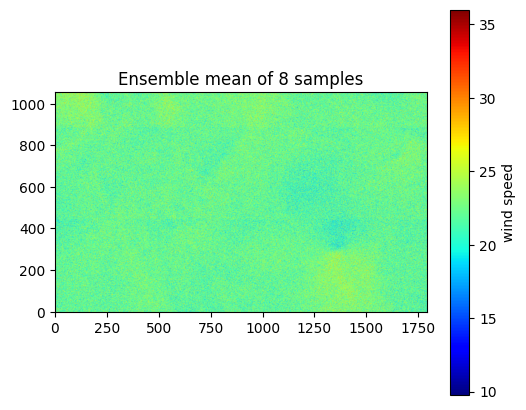

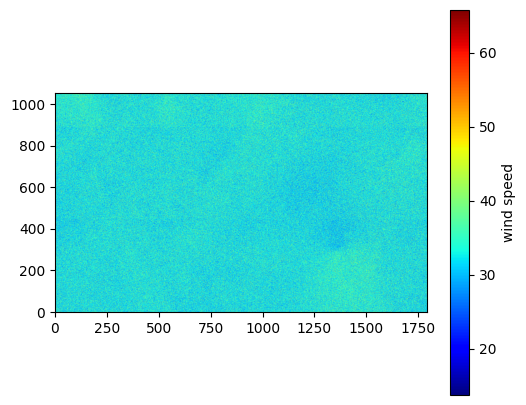

In [26]:
# make the ensemble visual 

def denormalize_output(normalized_output, means, stds):
    """
    Denormalize model output from HRRR normalized space to physical units
    Note: Channel 2 (t2m) is already in physical units, don't denormalize it!
    """
    denormalized = normalized_output.copy()
    
    # Denormalize each channel individually
    # Channel 0: u10m
    denormalized[0, 0, 0] = (normalized_output[0, 0, 0] * stds[0,0,0]) + means[0,0,0]
    
    # Channel 1: v10m
    denormalized[0, 0, 1] = (normalized_output[0, 0, 1] * stds[1,0,0]) + means[1,0,0]
    
    # Channel 2: t2m - ALREADY IN PHYSICAL UNITS, DON'T TOUCH
    # denormalized[0, 0, 2] = normalized_output[0, 0, 2]  # Already done by copy
    
    # Channels 3-7: precipitation variables (skip channel 3 in normalization file)
    # Use channels 4-8 from the normalization file
    for i in range(3, 8):
        denormalized[0, 0, i] = (normalized_output[0, 0, i] * stds[i+1,0,0]) + means[i+1,0,0]
    
    return denormalized

# Process output
output_means = np.load("corrdiff_us_hrrr_means.npy")
output_stds = np.load("corrdiff_us_hrrr_stds.npy")

sample = []
u = []
v = []

with tarfile.open("output.tar") as tar:
    for i, member in enumerate(tar.getmembers()):
        arr_file = io.BytesIO()
        arr_file.write(tar.extractfile(member).read())
        arr_file.seek(0)
        data = np.load(arr_file)

        data_denormalized = denormalize_output(data, output_means, output_stds)
        u10m = data_denormalized[0, 0, 0]
        v10m = data_denormalized[0, 0, 1]
        wind_10m_norm = np.sqrt(u10m**2 + v10m**2)

        sample.append(wind_10m_norm)
        u.append(u10m)
        v.append(v10m)

sample = np.array(sample)
ensemble_mean = np.mean(sample, axis = 0)
ensemble_per = np.percentile(sample, 100, axis = 0)
#ensemble_std = np.std(sample, axis = 0)
ensemble_u = np.mean(u, axis = 0)
ensemble_v = np.mean(v, axis = 0)

fig, ax = plt.subplots(1,1, figsize = (6,5))
ax.set_title("Ensemble mean of all samples")
im = ax.imshow(ensemble_mean, origin = "lower", cmap = "jet")
plt.colorbar(im, ax = ax, label = "wind speed")
plt.show()

fig, ax = plt.subplots(1,1, figsize = (6,5))
im = ax.imshow(ensemble_per, origin = "lower", cmap = "jet") # <--- this is the variable we will use 
plt.colorbar(im, ax = ax, label = "wind speed")
plt.show()


In [27]:

# The corrdinate system of corrdiff 
import numpy as np

# Load official NVIDIA coordinates
lats = np.load("corrdiff_output_lat.npy")
lons = np.load("corrdiff_output_lon.npy")

print(f"Latitudes: {lats.shape} - Range: {lats.min():.2f}° to {lats.max():.2f}°")
print(f"Longitudes: {lons.shape} - Range: {lons.min():.2f}° to {lons.max():.2f}°")
print(f"Resolution: ~{(lats.max()-lats.min())/len(lats):.4f}° lat × {(lons.max()-lons.min())/len(lons):.4f}° lon")

Latitudes: (1056, 1792) - Range: 21.19° to 52.56°
Longitudes: (1056, 1792) - Range: 226.08° to 298.94°
Resolution: ~0.0297° lat × 0.0690° lon
Latitude spacing uniformity:
  Row-wise std: 0.005096
  Mean: -0.000003

Longitude spacing uniformity:
  Column-wise std: 0.006630
  Mean: 0.000004


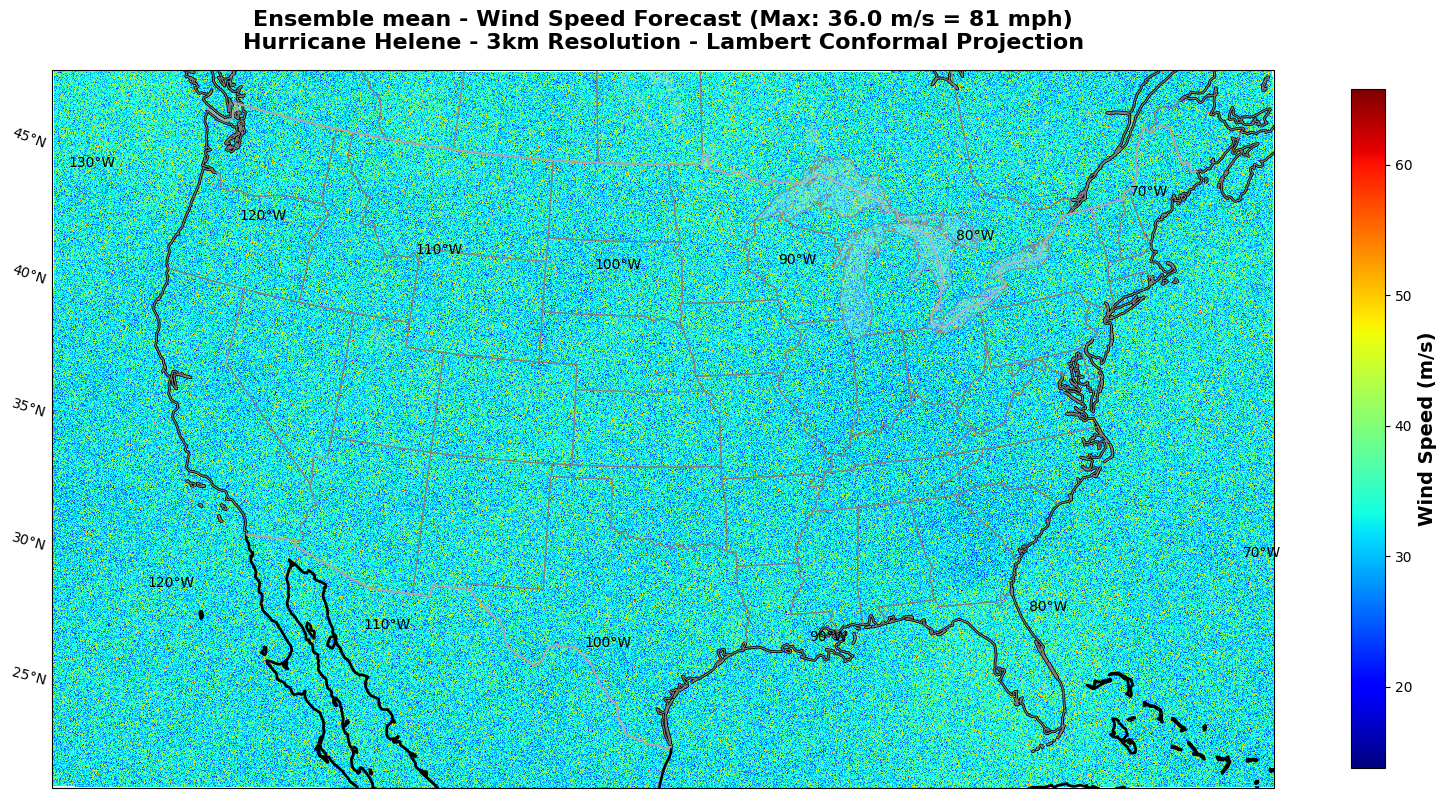

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter


# Load official coordinates
lats = np.load("corrdiff_output_lat.npy")
lons = np.load("corrdiff_output_lon.npy")
lons_west = lons - 360

# Set up Lambert Conformal projection
projection = ccrs.LambertConformal(
    central_longitude=np.median(lons_west),
    central_latitude=np.median(lats),
    standard_parallels=(33, 45)
)

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=projection)
        
        # Plot smoothed data
c = ax.pcolormesh(
        lons_west, lats, 
        ensemble_per,
        transform=ccrs.PlateCarree(),
        cmap='jet',
        )
        
        # Add geographic features
ax.coastlines(linewidth=2, color='black')
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='darkgray')
ax.add_feature(cfeature.LAKES, alpha=0.3, facecolor='lightblue')
ax.add_feature(cfeature.OCEAN, alpha=0.2, facecolor='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Title with statistics
max_wind = ensemble_mean.max()
ax.set_title(
    f"Ensemble mean - Wind Speed Forecast (Max: {max_wind:.1f} m/s = {max_wind*2.237:.0f} mph)\n"
    f"Hurricane Helene - 3km Resolution - Lambert Conformal Projection",
    fontsize=16, fontweight='bold', pad=15
)

# Colorbar
cbar = plt.colorbar(c, ax=ax, shrink=0.7, pad=0.05)
cbar.set_label('Wind Speed (m/s)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


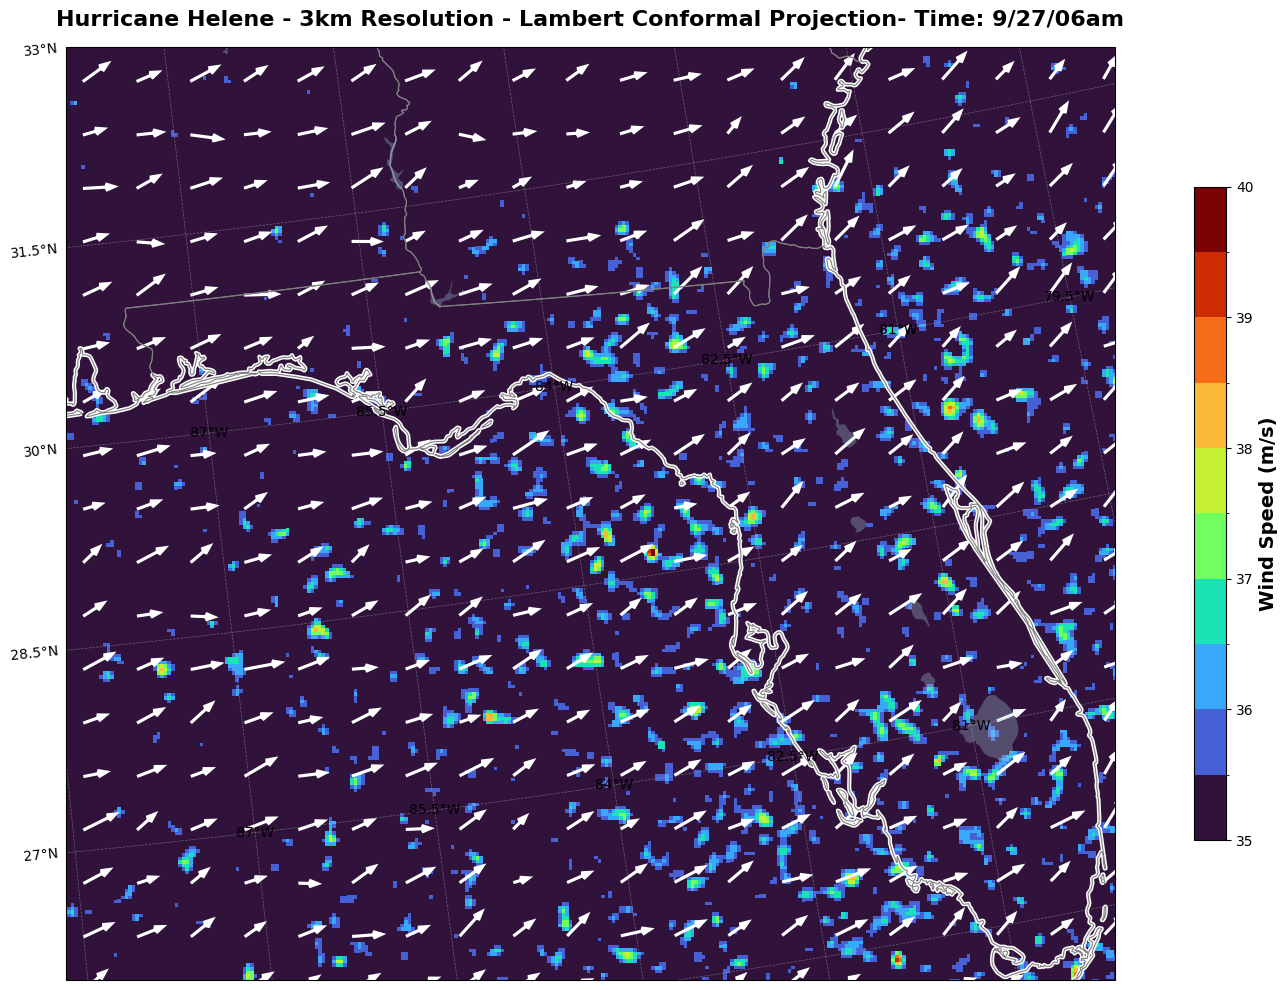

26.222775


In [36]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ---------- load grids ----------
lats = np.load("corrdiff_output_lat.npy")
lons = np.load("corrdiff_output_lon.npy")
lons_west = lons - 360

# ---------- map projection ----------
projection = ccrs.LambertConformal(
    central_longitude=float(np.mean(lons_west)),
    central_latitude=float(np.mean(lats)),
    standard_parallels=(33, 45)
)
pc = ccrs.PlateCarree()

# Florida Big Bend extent
la_lon = [-88.0, -80.0]
la_lat = [26, 32.0]

# ---------- Get ensemble mean u and v components ----------


# ---------- Create plot ----------
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=projection)

# Plot wind speed (color background)

levels = [35, 35.5, 36, 36.5, 37, 37.5, 38, 38.5, 39, 39.5, 40]
norm = mcolors.BoundaryNorm(levels, ncolors = 256)
c = ax.pcolormesh(
    lons_west, lats,
    gaussian_filter(ensemble_per, sigma = 1.3),
    transform=pc,
    norm = norm, 
    cmap='turbo'
)

# Set the view extent
ax.set_extent([la_lon[0], la_lon[1], la_lat[0], la_lat[1]], crs=pc)


# Add the quiver plot 
skip = 15  # Plot every 30th point (adjust for density)

quiver = ax.quiver(
    lons_west[::skip, ::skip], 
    lats[::skip, ::skip],
    ensemble_u[::skip, ::skip],
    ensemble_v[::skip, ::skip],
    transform=pc,
    color='white',           # Arrow color          
    scale = 700, # Arrow size (smaller = longer arrows)
    width=0.003,             # Arrow shaft width
    headwidth=3,             # Arrow head width
    headlength=4,            # Arrow head length
)

# Add quiver plot 
quiver

# Add geographic features
ax.coastlines(linewidth=3, color='white')
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='darkgray')
ax.add_feature(cfeature.LAKES, alpha=0.3, facecolor='lightblue')
ax.add_feature(cfeature.OCEAN, alpha=0.2, facecolor='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


ax.set_title(
    f"Hurricane Helene - 3km Resolution - Lambert Conformal Projection"
    f"- Time: 9/27/06am",
    fontsize=16, fontweight='bold', pad=15
)

# Colorbar
cbar = plt.colorbar(c, ax=ax, shrink=0.7, pad=0.05)
cbar.set_label('Wind Speed (m/s)', fontsize=14, fontweight='bold')
plt.savefig("HurrHele_sample_27_06.png", dpi = 300)
plt.tight_layout()
plt.show()
